# Lesson 4 - Data Generation
- 이번 실습자료에서는 파이토치 모델에 이미지를 입력값으로 주기위해 전처리를 하는 방법을 배웁니다.
- 파이토치는 torch.utils.data에 있는 Dataset, DataLoader 클래스가 이 작업을 간편하게 해줍니다.
## 0. Libraries & Configurations
- 시각화에 필요한 라이브러리와 데이터 경로를 설정합니다.

In [1]:
import os
import sys
from glob import glob
import numpy as np
import pandas as pd
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from time import time

import torch
import torch.utils.data as data

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
### Configurations
data_dir = '/mnt/ssd/data/mask_final/train'
img_dir = f'{data_dir}/images'
df_path = f'{data_dir}/train.csv'

In [3]:
df = pd.read_csv(df_path)
df.head()

,id,gender,race,age,path
0,000001,female,Asian,45,000001_female_Asian_45
1,000002,female,Asian,52,000002_female_Asian_52
2,000004,male,Asian,54,000004_male_Asian_54
3,000005,female,Asian,58,000005_female_Asian_58
4,000006,female,Asian,59,000006_female_Asian_59


## 1. Image Statistics

- 2강 실습자료에서 사용되었던 데이터셋의 RGB 평균, 표준편차를 구하는 함수를 이용하여 그에 대해 계산합니다.

In [4]:
def get_ext(img_dir, img_id):
    filename = os.listdir(os.path.join(img_dir, img_id))[0]
    ext = os.path.splitext(filename)[-1].lower()
    return ext

In [5]:
def get_img_stats(img_dir, img_ids):
    img_info = dict(heights=[], widths=[], means=[], stds=[])
    for img_id in tqdm(img_ids):
        for path in glob(os.path.join(img_dir, img_id, '*')):
            img = np.array(Image.open(path))
            h, w, _ = img.shape
            img_info['heights'].append(h)
            img_info['widths'].append(w)
            img_info['means'].append(img.mean(axis=(0,1)))
            img_info['stds'].append(img.std(axis=(0,1)))
    return img_info

In [6]:
img_info = get_img_stats(img_dir, df.path.values)

print(f'RGB Mean: {np.mean(img_info["means"], axis=0) / 255.}')
print(f'RGB Standard Deviation: {np.mean(img_info["stds"], axis=0) / 255.}')


RGB Mean: [0.56019358 0.52410121 0.501457  ]
RGB Standard Deviation: [0.23318603 0.24300033 0.24567522]


## 2. Dataset
- 이 부분에서는 Dataset을 정의하는 방법을 간단하게 배웁니다.

## 2.1 Augmentation Function
- 3강에서 배운 Augmentation 함수를 정의합니다.
- mean, std는 임의로 설정하였으나 파트 1에서 계산한 값을 입력해도 괜찮습니다.

In [7]:
mean, std = (0.5, 0.5, 0.5), (0.2, 0.2, 0.2)

### 2.1.1 Torchvision Style Augmentation Function
- Torchvision에서 제공되는 transforms를 이용한 Augmentation 함수입니다.
- 이를 사용하여 Dataset을 정의하여도 괜찮지만, 이번 실습자료에서는 강의에서 배웠던 Albumentation을 활용해봅시다.

In [8]:
''' Torchvision-Style Transforms
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Normalize, GaussianBlur, RandomRotation, ColorJitter


class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


def get_transforms(need=('train', 'val'), img_size=(512, 384)):
    transformations = {}
    if 'train' in need:
        transformations['train'] = transforms.Compose([
            Resize((img_size[0], img_size[1])),
            RandomRotation([-8, +8]),
            GaussianBlur(51, (0.1, 2.0)),
            ColorJitter(brightness=0.5, saturation=0.5, hue=0.5),  # todo : param
            ToTensor(),
            Normalize(mean=mean, std=std),
            AddGaussianNoise(0., 1.)
        ])
    if 'val' in need:
        transformations['val'] = transforms.Compose([
            Resize((img_size[0], img_size[1])),
            ToTensor(),
            Normalize(mean=mean, std=std),
        ])
    return transformations
'''

" Torchvision-Style Transforms\nfrom torchvision import transforms\nfrom torchvision.transforms import Resize, ToTensor, Normalize, GaussianBlur, RandomRotation, ColorJitter\n\n\nclass AddGaussianNoise(object):\n    def __init__(self, mean=0., std=1.):\n        self.std = std\n        self.mean = mean\n\n    def __call__(self, tensor):\n        return tensor + torch.randn(tensor.size()) * self.std + self.mean\n\n    def __repr__(self):\n        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)\n\n\ndef get_transforms(need=('train', 'val'), img_size=(512, 384)):\n    transformations = {}\n    if 'train' in need:\n        transformations['train'] = transforms.Compose([\n            Resize((img_size[0], img_size[1])),\n            RandomRotation([-8, +8]),\n            GaussianBlur(51, (0.1, 2.0)),\n            ColorJitter(brightness=0.5, saturation=0.5, hue=0.5),  # todo : param\n            ToTensor(),\n            Normalize(mean=mean, std=std),\n       

### 2.1.2 Albumentation Style Augmentation Function
- Albumentation은 numpy 형식으로 이미지를 받아 데이터를 변형시킵니다.
- opencv 기반으로 빠르고, 다양한 Augmentation 방법이 제공되는 점에서 장점이 있습니다.

In [9]:
from albumentations import *
from albumentations.pytorch import ToTensorV2


def get_transforms(need=('train', 'val'), img_size=(512, 384)):
    """
    train 혹은 validation의 augmentation 함수를 정의합니다. train은 데이터에 많은 변형을 주어야하지만, validation에는 최소한의 전처리만 주어져야합니다.
    
    Args:
        need: 'train', 혹은 'val' 혹은 둘 다에 대한 augmentation 함수를 얻을 건지에 대한 옵션입니다.
        img_size: Augmentation 이후 얻을 이미지 사이즈입니다.

    Returns:
        transformations: Augmentation 함수들이 저장된 dictionary 입니다. transformations['train']은 train 데이터에 대한 augmentation 함수가 있습니다.
    """
    transformations = {}
    if 'train' in need:
        transformations['train'] = Compose([
            Resize(img_size[0], img_size[1], p=1.0),
            HorizontalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            GaussNoise(p=0.5),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
    if 'val' in need:
        transformations['val'] = Compose([
            Resize(img_size[0], img_size[1]),
            Normalize(mean=mean, std=std, max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.0)
    return transformations

### 2.2 Define Dataset
- 여기에서는 이미지와 마스크의 여부만 데이터를 출력하는 Dataset 클래스를 정의합니다.

In [10]:
class MaskBaseDataset(data.Dataset):    
    def __init__(self, img_paths, labels,
                 phase="train", img_size=(512, 384)):
        """
        MaskBaseDataset을 initialize 합니다.

        Args:
            img_paths: 이미지들의 경로 리스트입니다.
            labels: 이미지들의 마스크 유무입니다. (착용-0, 이상하게 착용-1, 미착용-2)
            phase: Dataset을 학습에 사용할 건지, validation에 사용할 건지 설정합니다. ('train', 'val')
            img_size: Augmentation 이후 얻을 이미지 사이즈입니다.
        """
        self.img_paths = img_paths
        self.labels = labels
        self.transform = get_transforms(img_size=img_size)[phase]
        
    def __getitem__(self, index):
        # 이미지와 레이블을 불러옵니다.
        image = Image.open(self.img_paths[index])
        label = self.labels[index]
        
        if self.transform:
            # 이미지를 Augmentation 시킵니다.
            image = self.transform(image=np.array(image))['image']
        return image, label

    def __len__(self):
        # 전체 이미지가 몇 장있는지 반환합니다.
        return len(self.img_paths)

In [11]:
IMG_EXTENSIONS = [
    ".jpg", ".JPG", ".jpeg", ".JPEG", ".png",
    ".PNG", ".ppm", ".PPM", ".bmp", ".BMP",
]

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)


class Labels:
    mask = 0
    incorrect = 1
    normal = 2

    
_file_names = {
    "mask1": Labels.mask,
    "mask2": Labels.mask,
    "mask3": Labels.mask,
    "mask4": Labels.mask,
    "mask5": Labels.mask,
    "incorrect_mask": Labels.incorrect,
    "normal": Labels.normal
}


# 이미지들의 경로를 리스트로 저장합니다.
img_paths = []
for img_id in df.path:
    img_paths.extend(glob(os.path.join(img_dir, img_id, '*')))
img_paths = list(filter(is_image_file, img_paths))


# 각 이미지들의 레이블을 구합니다.
labels = []
for path in img_paths:
    filename = os.path.splitext(os.path.basename(path))[0]  # mask3
    labels.append(_file_names[filename])

In [12]:
# 전체 데이터셋을 training: validation으로 8:2 비율로 나눕니다.
X_train, X_val, y_train, y_val = train_test_split(img_paths, labels,
                                                  test_size=0.2, random_state=42)

In [13]:
# training, validation dataset을 정의합니다.
train_dataset = MaskBaseDataset(X_train, y_train, phase='train')
val_dataset = MaskBaseDataset(X_val, y_val, phase='val')

## 3. DataLoader
- 정의한 Dataset을 바탕으로 DataLoader을 생성합니다.
- Dataset은 이미지 한장을 주는 모듈이라면, DataLoader은 여러 이미지를 batch_size만큼 묶어 전달해줍니다.

In [14]:
# training dataloader은 데이터를 섞어주어야 합니다. (shuffle=True)
train_loader = data.DataLoader(
    train_dataset,
    batch_size=12,
    num_workers=4,
    shuffle=True
)

val_loader = data.DataLoader(
    val_dataset,
    batch_size=12,
    num_workers=4,
    shuffle=False
)

## 4.  Visualize Processed Data
- 파트 4에선 정의한 DataLoader을 이용하여 데이터가 어떻게 전처리 되었는지 시각화하여 확인합니다.

In [15]:
images, labels = next(iter(train_loader))
print(f'images shape: {images.shape}')
print(f'labels shape: {labels.shape}')

images shape: torch.Size([12, 3, 512, 384])
labels shape: torch.Size([12])


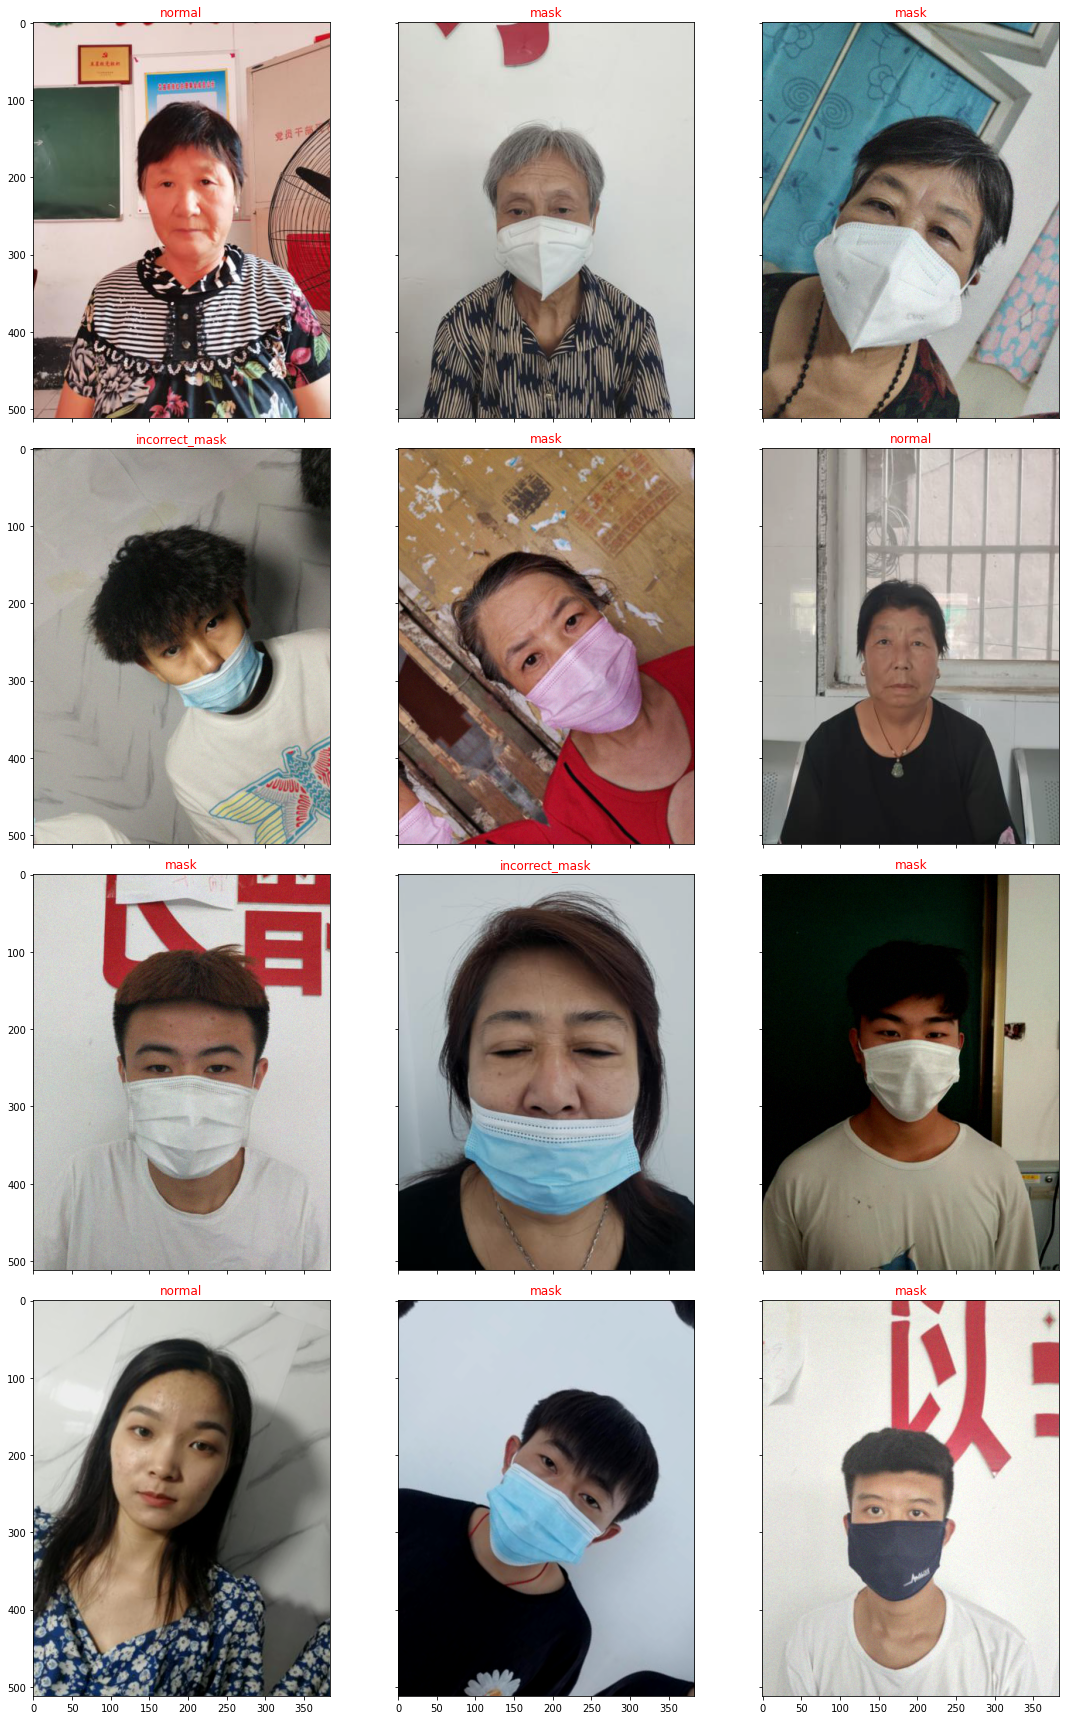

In [16]:
from torchvision import transforms

# Augmentation으로 이미지를 Normalize했기 때문에, 역으로 다시 Normalize 해주어야합니다.
inv_normalize = transforms.Normalize(
    mean=[-m / s for m, s in zip(mean, std)],
    std=[1 / s for s in std]
)
num2class = ['mask', 'incorrect_mask', 'normal']

n_rows, n_cols = 4, 3

fig, axes = plt.subplots(n_rows, n_cols, sharex=True, sharey=True, figsize=(16, 24))
for i in range(n_rows*n_cols):
    axes[i%n_rows][i//(n_cols+1)].imshow(inv_normalize(images[i]).permute(1, 2, 0))
    axes[i%n_rows][i//(n_cols+1)].set_title(f'{num2class[labels[i]]}', color='r')
plt.tight_layout()